In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from __future__ import print_function
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
# Read data
os.chdir('/content/drive/My Drive/Colab Notebooks')
datapath = os.getcwd()+'/Data/'
file = datapath + 'CreditCardData.csv'
df = pd.read_csv('CreditCardData.csv')

# Rename column 'PAY_0' as 'PAY_1'
df.rename(columns = {'PAY_0' : 'PAY_1'}, inplace = True)

# Print dataframe and column datatypes
pd.options.display.max_columns = None
print(df.head(5))
#print(df.dtypes)

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   
4      0      0     8617.0     5670.0    35835.0    20940.0    19146.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0   

In [ ]:
# Create lists of continuous and categorical column names
continuous_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                   'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month']

# Assign 'object' datatype to categorical columns
df[categorical_cols] = df[categorical_cols].astype('category')

# Print unique values for categorical columns
unique_values = {col:list(df[col].unique()) for col in categorical_cols}
for key, value in unique_values.items():
  print(key,value)

SEX [2, 1]
EDUCATION [2, 1, 3, 5, 4, 6, 0]
MARRIAGE [1, 2, 3, 0]
PAY_1 [2, -1, 0, -2, 1, 3, 4, 8, 7, 5, 6]
PAY_2 [2, 0, -1, -2, 3, 5, 7, 4, 1, 6, 8]
PAY_3 [-1, 0, 2, -2, 3, 4, 6, 7, 1, 5, 8]
PAY_4 [-1, 0, -2, 2, 3, 4, 5, 7, 6, 1, 8]
PAY_5 [-2, 0, -1, 2, 3, 5, 4, 7, 8, 6]
PAY_6 [-2, 2, 0, -1, 3, 6, 4, 7, 8, 5]
default.payment.next.month [1, 0]


In [ ]:
# Adjust categorical column values for misrepresented entries
df.loc[~df['EDUCATION'].isin([1, 2, 3, 4]), 'EDUCATION'] = 5
df.loc[~df['MARRIAGE'].isin([1, 2]), 'MARRIAGE'] = 3
df.loc[~df['PAY_1'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_1'] = 0
df.loc[~df['PAY_2'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_2'] = 0
df.loc[~df['PAY_3'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_3'] = 0
df.loc[~df['PAY_4'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_4'] = 0
df.loc[~df['PAY_5'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_5'] = 0
df.loc[~df['PAY_6'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_6'] = 0
categorical_cols = categorical_cols[:-1]

In [ ]:
# Calculate correlation between continuous & continuous variables
# using Spearman's correlation coefficient
corr = pd.DataFrame(columns = continuous_cols + categorical_cols,
                    index =  continuous_cols + categorical_cols)
corr[continuous_cols] = df[continuous_cols].corr(method ='spearman')
print(corr)

           LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
LIMIT_BAL   1.000000  0.186485   0.054384   0.048586   0.060617   0.072894   
AGE         0.186485  1.000000   0.001019   0.001513   0.001831  -0.003330   
BILL_AMT1   0.054384  0.001019   1.000000   0.911133   0.857723   0.807302   
BILL_AMT2   0.048586  0.001513   0.911133   1.000000   0.907740   0.848381   
BILL_AMT3   0.060617  0.001831   0.857723   0.907740   1.000000   0.903640   
BILL_AMT4   0.072894 -0.003330   0.807302   0.848381   0.903640   1.000000   
BILL_AMT5   0.080694 -0.000342   0.769048   0.802947   0.848547   0.902787   
BILL_AMT6   0.088094  0.000217   0.734275   0.765220   0.804246   0.847983   
PAY_AMT1    0.272367  0.033580   0.502339   0.635634   0.549733   0.512285   
PAY_AMT2    0.278401  0.044192   0.472158   0.497603   0.637539   0.554883   
PAY_AMT3    0.284468  0.033356   0.440547   0.468164   0.491950   0.633535   
PAY_AMT4    0.283411  0.040529   0.441925   0.461064   0.488544 

In [ ]:
# Function to calculate correlation between continuous & categorical variables
# using Correlation Ratio

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [ ]:
# Calculate correlation between continuous &  categorical variables using
# Correlation Ratio

for con_col_name in continuous_cols:
  for cat_col_name in categorical_cols:
    val = correlation_ratio(df[con_col_name].values,
                            df[cat_col_name].astype('float64').values)
    corr.loc[con_col_name, cat_col_name] = val
    corr.loc[cat_col_name, con_col_name] = val
print(corr)

           LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
LIMIT_BAL   1.000000  0.186485   0.054384   0.048586   0.060617   0.072894   
AGE         0.186485  1.000000   0.001019   0.001513   0.001831  -0.003330   
BILL_AMT1   0.054384  0.001019   1.000000   0.911133   0.857723   0.807302   
BILL_AMT2   0.048586  0.001513   0.911133   1.000000   0.907740   0.848381   
BILL_AMT3   0.060617  0.001831   0.857723   0.907740   1.000000   0.903640   
BILL_AMT4   0.072894 -0.003330   0.807302   0.848381   0.903640   1.000000   
BILL_AMT5   0.080694 -0.000342   0.769048   0.802947   0.848547   0.902787   
BILL_AMT6   0.088094  0.000217   0.734275   0.765220   0.804246   0.847983   
PAY_AMT1    0.272367  0.033580   0.502339   0.635634   0.549733   0.512285   
PAY_AMT2    0.278401  0.044192   0.472158   0.497603   0.637539   0.554883   
PAY_AMT3    0.284468  0.033356   0.440547   0.468164   0.491950   0.633535   
PAY_AMT4    0.283411  0.040529   0.441925   0.461064   0.488544 

In [ ]:
# Function to calculate correlation between categorical & categorical variables
# using Cramer's V

def cramers_phi(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
# Calculate correlation between categorical & categorical variables
# using Cramer's V
for col in [categorical_cols, categorical_cols]:
  for i in range(0,len(col)):
    for j in range(i,len(col)):
      if i == j:
        corr.loc[col[i],col[j]] = 1.0
      else:
        val = cramers_phi(df[col[i]].astype('float64').values,
                          df[col[j]].astype('float64').values)
        corr.loc[col[i], col[j]] = val
        corr.loc[col[j], col[i]] = val
print(corr)

           LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
LIMIT_BAL   1.000000  0.186485   0.054384   0.048586   0.060617   0.072894   
AGE         0.186485  1.000000   0.001019   0.001513   0.001831  -0.003330   
BILL_AMT1   0.054384  0.001019   1.000000   0.911133   0.857723   0.807302   
BILL_AMT2   0.048586  0.001513   0.911133   1.000000   0.907740   0.848381   
BILL_AMT3   0.060617  0.001831   0.857723   0.907740   1.000000   0.903640   
BILL_AMT4   0.072894 -0.003330   0.807302   0.848381   0.903640   1.000000   
BILL_AMT5   0.080694 -0.000342   0.769048   0.802947   0.848547   0.902787   
BILL_AMT6   0.088094  0.000217   0.734275   0.765220   0.804246   0.847983   
PAY_AMT1    0.272367  0.033580   0.502339   0.635634   0.549733   0.512285   
PAY_AMT2    0.278401  0.044192   0.472158   0.497603   0.637539   0.554883   
PAY_AMT3    0.284468  0.033356   0.440547   0.468164   0.491950   0.633535   
PAY_AMT4    0.283411  0.040529   0.441925   0.461064   0.488544 

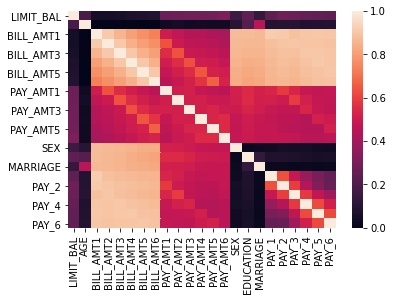

In [ ]:
# Plot the correlation matrix
corr.fillna(value=np.nan, inplace=True)
sns.heatmap(corr)

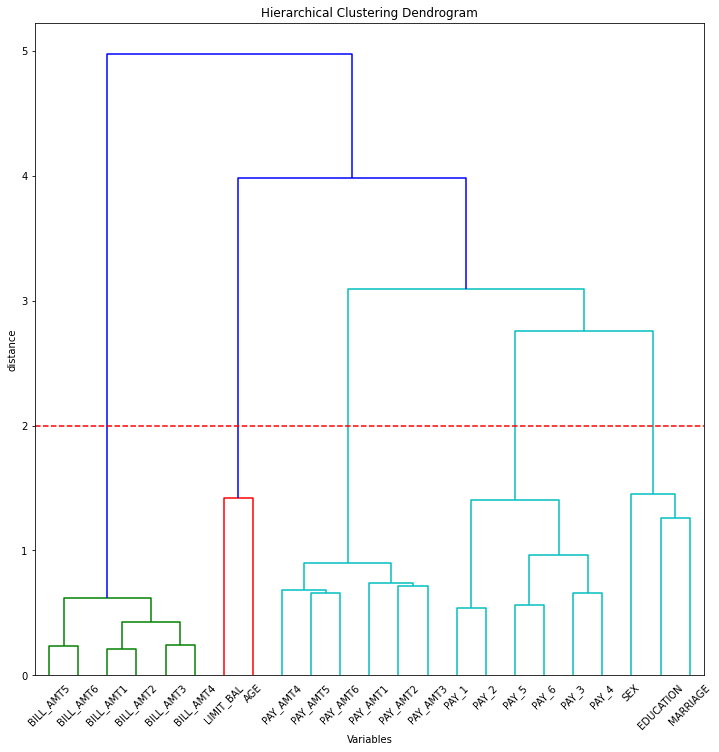

In [ ]:
## Hierarchichal clustering of the correlation matrix
# Generate the linkage matrix
Z = linkage(corr, 'ward')

# Calculate full dendrogram
plt.figure(figsize=(12, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variables')
plt.ylabel('distance')
dendrogram(Z, labels=list(corr.columns))
plt.axhline(y=2, color='r', linestyle='--')
plt.show()

In [ ]:
# Install Java
! apt-get install default-jre
! java -version
# Install h2o library for GLRM
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
import h2o # For GLRM
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
h2o.init()
h2o.remove_all() # Clean slate - just in case the cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,18 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_cig9ws
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.176 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Write updated dataframe into a single CSV file
df.to_csv('Data/CreditCardDataUpdated.csv', columns = df.columns)

In [ ]:
# Import data as h2o dataframe
dfh2o = h2o.import_file(path = os.path.realpath("Data/CreditCardDataUpdated.csv"))
dfh2o.types

Parse progress: |█████████████████████████████████████████████████████████| 100%


{'AGE': 'int',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'C1': 'int',
 'EDUCATION': 'int',
 'ID': 'int',
 'LIMIT_BAL': 'int',
 'MARRIAGE': 'int',
 'PAY_1': 'int',
 'PAY_2': 'int',
 'PAY_3': 'int',
 'PAY_4': 'int',
 'PAY_5': 'int',
 'PAY_6': 'int',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int',
 'SEX': 'int',
 'default.payment.next.month': 'int'}

In [ ]:
# Reset categorical column data types in h2o dataframe
dfh2o[categorical_cols] = dfh2o[categorical_cols].asfactor()
dfh2o["default.payment.next.month"]=dfh2o["default.payment.next.month"].asfactor()
dfh2o.types

{'AGE': 'int',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'C1': 'int',
 'EDUCATION': 'enum',
 'ID': 'int',
 'LIMIT_BAL': 'int',
 'MARRIAGE': 'enum',
 'PAY_1': 'enum',
 'PAY_2': 'enum',
 'PAY_3': 'enum',
 'PAY_4': 'enum',
 'PAY_5': 'enum',
 'PAY_6': 'enum',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int',
 'SEX': 'enum',
 'default.payment.next.month': 'enum'}

In [ ]:
#Created 5 different dataframes which has the features corresponding to the particular cluster.
#Then each time while running GLRM model given each dataframe as the  training frame.
#This is not needed we can give directly the features corresponding to the particular cluster in the trainning frame..
dfh2o_c1=dfh2o[["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]]
dfh2o_c2=dfh2o[["AGE","LIMIT_BAL"]]
dfh2o_c3=dfh2o[["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]]
dfh2o_c4=dfh2o[["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]]
dfh2o_c5=dfh2o[["SEX","EDUCATION","MARRIAGE"]]
#dfh2o_list = [dfh2o_c1,dfh2o_c2,dfh2o_c3,dfh2o_c4,dfh2o_c5]
#print(dfh2o_list)


In [ ]:
# Basic GLRM using absolute loss for continuous and categorical loss for
# categorical columns with no regularization and with stadardized columns

In [ ]:
#model genearted for the first cluster :bill_amt1 to bill_amt6
model_c1 = H2OGeneralizedLowRankEstimator(k = 1,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model_c1.train(training_frame=dfh2o_c1)
model_c1.show()



glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592562208597_11


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,1000.0,0.000113,104999.442091




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 205111.72654136934
Misclassification Error (Categorical): 0.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 11:34:48,0.217 sec,0.0,0.666667,122395.625126
1,,2020-06-19 11:34:48,0.259 sec,1.0,0.444444,122395.625126
2,,2020-06-19 11:34:48,0.291 sec,2.0,0.222222,122395.625126
3,,2020-06-19 11:34:48,0.315 sec,3.0,0.074074,122395.625126
4,,2020-06-19 11:34:48,0.343 sec,4.0,0.018519,122395.625126
5,,2020-06-19 11:34:49,0.378 sec,5.0,0.003704,122395.625126
6,,2020-06-19 11:34:49,0.404 sec,6.0,0.000617,122395.625126
7,,2020-06-19 11:34:49,0.438 sec,7.0,0.000088,122395.625126
8,,2020-06-19 11:34:49,0.474 sec,8.0,0.000093,112819.019292
9,,2020-06-19 11:34:49,0.518 sec,9.0,0.000097,108797.066465



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model_c1._model_json["output"]["importance"]


Importance of components: 


,,pc1
0,Standard deviation,0.978438
1,Proportion of Variance,0.159557
2,Cumulative Proportion,0.159557


In [ ]:
# Split the feature matrix into product of two matrices X and Y
# The matrix X has the same number of rows as the original feature matrix
# but a reduced number of columns representing the original features
# GLRM matrix factors X and Y

In [ ]:
#X_matrix and Y_matrix for cluster1...
X_matrix_c1 = h2o.get_frame(model_c1._model_json["output"]["representation_name"])
print(X_matrix_c1)
Y_matrix_c1 = model_c1._model_json["output"]["archetypes"]
print(Y_matrix_c1)

Arch1
1.04703
1.04703
1.02877
0.952985
0.985673
0.958397
0.952975
1.04703
1.04703
1.04703




Archetypes: 


,,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,Arch1,-0.418339,-0.416531,-0.401725,-0.394765,-0.379768,-0.383853


In [ ]:
#model genearted for  cluster2 :age and limit balance
model_c2 = H2OGeneralizedLowRankEstimator(k = 1,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model_c2.train(training_frame=dfh2o_c2)
model_c2.show()

glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592562208597_13


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,23.0,7.319006e-07,47997.116795




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 61843.257122049166
Misclassification Error (Categorical): 0.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 11:35:35,0.114 sec,0.0,0.666667,48827.064066
1,,2020-06-19 11:35:35,0.124 sec,1.0,0.444444,48827.064066
2,,2020-06-19 11:35:35,0.135 sec,2.0,0.222222,48827.064066
3,,2020-06-19 11:35:35,0.143 sec,3.0,0.074074,48827.064066
4,,2020-06-19 11:35:35,0.153 sec,4.0,0.018519,48827.064066
5,,2020-06-19 11:35:35,0.164 sec,5.0,0.003704,48827.064066
6,,2020-06-19 11:35:35,0.171 sec,6.0,0.000617,48827.064066
7,,2020-06-19 11:35:35,0.182 sec,7.0,0.000088,48827.064066
8,,2020-06-19 11:35:35,0.193 sec,8.0,0.000093,48001.440597
9,,2020-06-19 11:35:35,0.205 sec,9.0,0.000062,48001.440597



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model_c2._model_json["output"]["importance"]


Importance of components: 


,,pc1
0,Standard deviation,0.248015
1,Proportion of Variance,0.030756
2,Cumulative Proportion,0.030756


In [ ]:
#X_matrix and Y_matrix for cluster2...
X_matrix_c2 = h2o.get_frame(model_c2._model_json["output"]["representation_name"])
print(X_matrix_c2)
Y_matrix_c2 = model_c2._model_json["output"]["archetypes"]
print(Y_matrix_c2)

Arch1
1
1
1
1
1
1
1
1
1
1




Archetypes: 


,,age,limit_bal
0,Arch1,-0.160932,-0.188707


In [ ]:
#model genearted for  cluster3 :pay_amt1 to pay_amt6
model_c3 = H2OGeneralizedLowRankEstimator(k = 1,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model_c3.train(training_frame=dfh2o_c3)
model_c3.show()

glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592562208597_15


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,50.0,7.518464e-07,48317.681622




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 187443.27260047622
Misclassification Error (Categorical): 0.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 11:35:41,0.182 sec,0.0,0.666667,60978.637895
1,,2020-06-19 11:35:41,0.219 sec,1.0,0.444444,60978.637895
2,,2020-06-19 11:35:41,0.245 sec,2.0,0.222222,60978.637895
3,,2020-06-19 11:35:41,0.280 sec,3.0,0.074074,60978.637895
4,,2020-06-19 11:35:41,0.304 sec,4.0,0.018519,60978.637895
5,,2020-06-19 11:35:41,0.322 sec,5.0,0.003704,60978.637895
6,,2020-06-19 11:35:41,0.339 sec,6.0,0.000617,60978.637895
7,,2020-06-19 11:35:41,0.358 sec,7.0,0.000088,60978.637895
8,,2020-06-19 11:35:41,0.378 sec,8.0,0.000093,50592.196458
9,,2020-06-19 11:35:41,0.399 sec,9.0,0.000062,50592.196458



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model_c3._model_json["output"]["importance"]


Importance of components: 


,,pc1
0,Standard deviation,0.498360
1,Proportion of Variance,0.041394
2,Cumulative Proportion,0.041394


In [ ]:
#X_matrix and Y_matrix for cluster3...
X_matrix_c3 = h2o.get_frame(model_c3._model_json["output"]["representation_name"])
print(X_matrix_c3)
Y_matrix_c3 = model_c3._model_json["output"]["archetypes"]
print(Y_matrix_c3)

Arch1
1.00011
1.00007
1.00006
1.00007
0.999996
1.00005
0.999883
1.00003
1.00007
1.00007




Archetypes: 


,,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,Arch1,-0.215132,-0.169802,-0.19455,-0.212346,-0.215913,-0.209005


In [ ]:
#Model generated for cluster4: pay1 to pay6
model_c4 = H2OGeneralizedLowRankEstimator(k = 1,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model_c4.train(training_frame=dfh2o_c4)
model_c4.show()

glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592562208597_17


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,692.0,9.009155e-07,276551.109134




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 0.0
Misclassification Error (Categorical): 59666.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 11:35:49,0.345 sec,0.0,0.666667,1.679332e+06
1,,2020-06-19 11:35:49,0.481 sec,1.0,0.444444,1.679332e+06
2,,2020-06-19 11:35:50,0.613 sec,2.0,0.222222,1.679332e+06
3,,2020-06-19 11:35:50,0.810 sec,3.0,0.074074,1.679332e+06
4,,2020-06-19 11:35:50,1.012 sec,4.0,0.018519,1.679332e+06
5,,2020-06-19 11:35:50,1.225 sec,5.0,0.003704,1.679332e+06
6,,2020-06-19 11:35:50,1.370 sec,6.0,0.003889,1.048013e+06
7,,2020-06-19 11:35:50,1.499 sec,7.0,0.002593,1.048013e+06
8,,2020-06-19 11:35:51,1.632 sec,8.0,0.001728,1.048013e+06
9,,2020-06-19 11:35:51,1.769 sec,9.0,0.001815,9.836746e+05



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model_c4._model_json["output"]["importance"]


Importance of components: 


,,pc1
0,Standard deviation,2.449531
1,Proportion of Variance,1.000000
2,Cumulative Proportion,1.000000


In [ ]:
#X_matrix and Y_matrix for cluster4...
X_matrix_c4 = h2o.get_frame(model_c4._model_json["output"]["representation_name"])
print(X_matrix_c4)
Y_matrix_c4 = model_c4._model_json["output"]["archetypes"]
print(Y_matrix_c4)

Arch1
0.88025
0.904262
0.999731
0.999731
0.962453
0.999731
0.999731
0.934779
0.972236
0.952284




Archetypes: 


,,pay_11,pay_10,pay_11,pay_12,pay_13,pay_14,pay_15,pay_16,pay_17,pay_18,pay_21,pay_20,pay_21,pay_22,pay_23,pay_24,pay_25,pay_26,pay_27,pay_28,pay_31,pay_30,pay_31,pay_32,pay_33,pay_34,pay_35,pay_36,pay_37,pay_38,pay_41,pay_40,pay_41,pay_42,pay_43,pay_44,pay_45,pay_46,pay_47,pay_48,pay_51,pay_50,pay_52,pay_53,pay_54,pay_55,pay_56,pay_57,pay_58,pay_61,pay_60,pay_62,pay_63,pay_64,pay_65,pay_66,pay_67,pay_68
0,Arch1,-1.073775,1.000609,-1.1631,-3.588407,-16.789994,-18.10178,-18.363926,-18.441484,-18.453115,-18.407333,-1.065127,1.000171,-18.339983,-1.136037,-16.765258,-17.99582,-18.372084,-18.438743,-18.402561,-18.491019,-1.065081,1.000393,-18.474699,-1.135916,-17.247569,-18.121065,-18.394795,-18.388072,-18.364818,-18.481265,-1.068144,1.004836,-18.485583,-1.210573,-17.573829,-18.157611,-18.32913,-18.471296,-18.21277,-18.486165,-1.073763,1.021674,-4.202018,-17.58588,-18.084344,-18.411875,-18.476291,-18.212504,-18.490931,-1.073534,1.018668,-3.320534,-17.548244,-18.251907,-18.430924,-18.400272,-18.271281,-18.486157


In [ ]:
#Model generated for cluster5: Gender,Education and marriage
model_c5 = H2OGeneralizedLowRankEstimator(k = 1,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model_c5.train(training_frame=dfh2o_c5)
model_c5.show()

glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592562208597_19


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,68.0,8.712454e-07,173814.104374




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 0.0
Misclassification Error (Categorical): 41894.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 11:40:42,0.183 sec,0.0,0.666667,293788.000000
1,,2020-06-19 11:40:43,0.249 sec,1.0,0.444444,293788.000000
2,,2020-06-19 11:40:43,0.283 sec,2.0,0.222222,293788.000000
3,,2020-06-19 11:40:43,0.317 sec,3.0,0.074074,293788.000000
4,,2020-06-19 11:40:43,0.346 sec,4.0,0.018519,293788.000000
5,,2020-06-19 11:40:43,0.377 sec,5.0,0.003704,293788.000000
6,,2020-06-19 11:40:43,0.406 sec,6.0,0.000617,293788.000000
7,,2020-06-19 11:40:43,0.438 sec,7.0,0.000648,204163.725172
8,,2020-06-19 11:40:43,0.470 sec,8.0,0.000432,204163.725172
9,,2020-06-19 11:40:43,0.499 sec,9.0,0.000288,204163.725172



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model_c5._model_json["output"]["importance"]


Importance of components: 


,,pc1
0,Standard deviation,1.73208
1,Proportion of Variance,1.00000
2,Cumulative Proportion,1.00000


In [ ]:
#X_matrix and Y_matrix for cluster5...
X_matrix_c5 = h2o.get_frame(model_c5._model_json["output"]["representation_name"])
print(X_matrix_c5)
Y_matrix_c5 = model_c5._model_json["output"]["archetypes"]
print(Y_matrix_c5)

Arch1
0.999451
1.00072
1.00072
0.999451
0.998069
0.998921
0.998921
1.00072
0.998314
0.998212




Archetypes: 


,,education1,education2,education3,education4,education5,marriage1,marriage2,marriage3,sex1,sex2
0,Arch1,-0.999067,-0.855265,-1.856096,-6.063151,-5.86839,-0.656157,0.674958,-5.840417,-0.999224,0.999394


In [ ]:
# Data for training and testing
#first converted the  X_matrix from each cluster to array
#Then concatenated all the 5 arrays in columnwise

a1 = np.array(h2o.as_list(X_matrix_c1))
a2 = np.array(h2o.as_list(X_matrix_c2))
a3 = np.array(h2o.as_list(X_matrix_c3))
a4 = np.array(h2o.as_list(X_matrix_c4))
a5 = np.array(h2o.as_list(X_matrix_c5))

X=np.concatenate((a1,a2,a3,a4,a5),axis=1)
print(X.shape)

y = df['default.payment.next.month'].to_numpy()
print(y.shape)

(30000, 5)
(30000,)


In [ ]:
# Stratified train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

In [ ]:
print(X_train.shape)

(22500, 5)


In [ ]:

# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_LR= classifier_LR.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_LR= confusion_matrix(y_test, y_pred_LR)
print ("Confusion Matrix : \n", cm_LR)

Confusion Matrix : 
 [[5724  117]
 [1412  247]]


In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_LR))

Accuracy :  0.7961333333333334


Text(0.5, 1.0, 'COnfusion matrix for Logestic Regression')

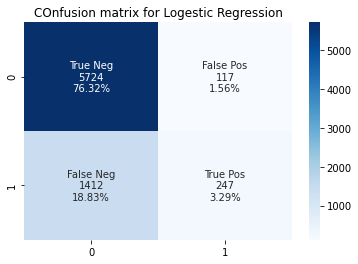

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_LR.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_LR.flatten()/np.sum(cm_LR)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_LR, annot=labels, fmt='', cmap='Blues')
plt.title("COnfusion matrix for Logestic Regression")

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_LR)
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_LR)
print('Recall: %.3f' % recall)

from sklearn.metrics import f1_score
score = f1_score(y_test, y_pred_LR)
print('F-Measure: %.3f' % score)

Precision: 0.679
Recall: 0.149
F-Measure: 0.244


In [ ]:
##SVM

In [ ]:
from sklearn.svm import SVC
classifier_SVM=SVC(kernel='rbf',random_state=0,probability=True)
classifier_SVM.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_SVM=classifier_SVM.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_SVM= confusion_matrix(y_test, y_pred_SVM)
print ("Confusion Matrix : \n", cm_SVM)

Confusion Matrix : 
 [[5662  179]
 [1322  337]]


In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_SVM))

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_SVM, average='binary')
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_SVM, average='binary')
print('Recall: %.3f' % recall)

from sklearn.metrics import f1_score
score = f1_score(y_test, y_pred_SVM, average='binary')
print('F-Measure: %.3f' % score)

Accuracy :  0.7998666666666666
Precision: 0.653
Recall: 0.203
F-Measure: 0.310


In [ ]:
##ROC curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [ ]:
# Get predicted probabilities
y_pred_prob_LR = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_SVM = classifier_SVM.predict_proba(X_test)[:,1]

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test,y_pred_prob_LR)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test,y_pred_prob_SVM)
roc_auc_LR = auc(fpr_LR, tpr_LR)
roc_auc_SVM= auc(fpr_SVM, tpr_SVM)
print("Area under the ROC curve for Logistic regression is  : %f" % roc_auc_LR)
print("Area under the ROC curve for SVM is  : %f" % roc_auc_SVM)

Area under the ROC curve for Logistic regression is  : 0.667362
Area under the ROC curve for SVM is  : 0.643799


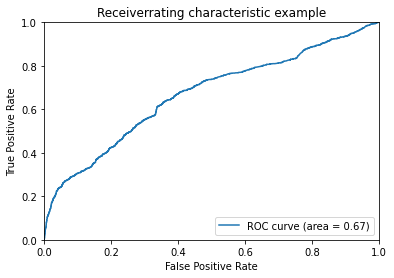

In [ ]:
import pylab as pl
pl.clf()
pl.plot(fpr_LR, tpr_LR, label='ROC curve (area = %0.2f)' % roc_auc_LR)
#pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiverrating characteristic example')
pl.legend(loc="lower right")
pl.show()

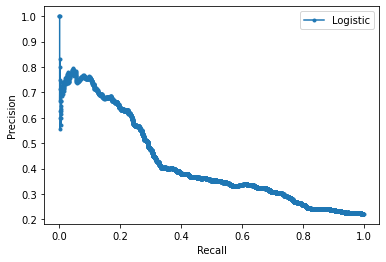

In [ ]:
#precision recall curve
precision, recall, _ = precision_recall_curve(y_test,y_pred_prob_LR)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

auc_score = auc(recall, precision)

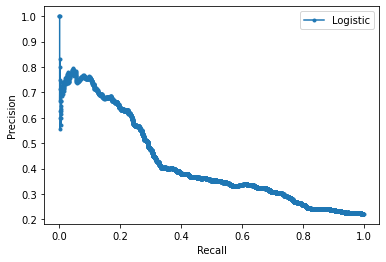

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_LR)
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


Text(0.5, 1.0, 'Precision-Recall curve  0.4225778819173132')

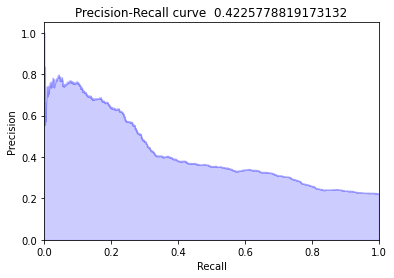

In [ ]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, y_pred_prob_LR)

#print('Average precision-recall score RF: {}'.format(average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_LR)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_prob_SVM)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve  {}".format(average_precision))

In [ ]:
###APPLYING OVERSAMPLING

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 4977
Before OverSampling, counts of label '0': 17523 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (35046, 5)
After OverSampling, the shape of train_y: (35046,) 

After OverSampling, counts of label '1': 17523
After OverSampling, counts of label '0': 17523


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_LR_OS = LogisticRegression(random_state = 0)
classifier_LR_OS.fit(X_train_res,y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_LR_OS= classifier_LR_OS.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_LR_OS= confusion_matrix(y_test, y_pred_LR_OS)
print ("Confusion Matrix : \n", cm_LR_OS)

Confusion Matrix : 
 [[4293 1548]
 [ 819  840]]


Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')

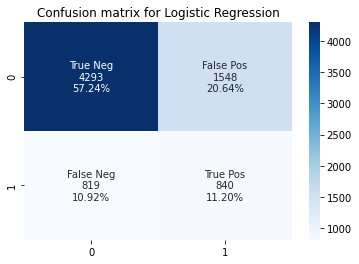

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_LR_OS.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_LR_OS.flatten()/np.sum(cm_LR_OS)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_LR_OS, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix for Logistic Regression")

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_LR_OS))

from sklearn.metrics import precision_score
precision_LR = precision_score(y_test, y_pred_LR_OS, average='binary')
print('Precision: %.3f' % precision_LR)

from sklearn.metrics import recall_score
recall_LR= recall_score(y_test, y_pred_LR_OS, average='binary')
print('Recall: %.3f' % recall_LR)

from sklearn.metrics import f1_score
score_LR = f1_score(y_test, y_pred_LR_OS, average='binary')
print('F-Measure: %.3f' % score_LR)

specificity_LR = cm_LR_OS[0,0]/(cm_LR_OS[0,0]+cm_LR_OS[0,1])
print('Specificity : ', specificity_LR)



Accuracy :  0.6844
Precision: 0.352
Recall: 0.506
F-Measure: 0.415
Specificity :  0.7349768875192604


In [ ]:
from sklearn.svm import SVC
classifier_SVM_OS=SVC(kernel='rbf',random_state=0,probability=True)
classifier_SVM_OS.fit(X_train_res,y_train_res)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:

y_pred_SVM_OS= classifier_SVM_OS.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_SVM_OS= confusion_matrix(y_test, y_pred_SVM_OS)
print ("Confusion Matrix : \n", cm_SVM_OS)

Confusion Matrix : 
 [[4229 1612]
 [ 760  899]]


Text(0.5, 1.0, 'Confusion matrix for SVM')

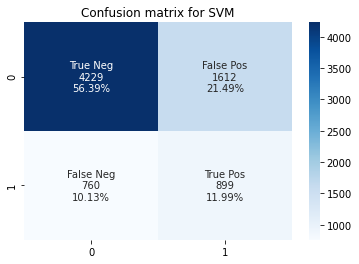

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_SVM_OS.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_SVM_OS.flatten()/np.sum(cm_SVM_OS)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_SVM_OS, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix for SVM")

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_SVM_OS))

from sklearn.metrics import precision_score
precision_SVM= precision_score(y_test, y_pred_SVM_OS, average='binary')
print('Precision: %.3f' % precision_SVM)

from sklearn.metrics import recall_score
recall_SVM = recall_score(y_test, y_pred_SVM_OS, average='binary')
print('Recall: %.3f' % recall_SVM)

from sklearn.metrics import f1_score
score_SVM= f1_score(y_test, y_pred_SVM_OS, average='binary')
print('F-Measure: %.3f' % score_SVM)

specificity_SVM = cm_SVM_OS[0,0]/(cm_SVM_OS[0,0]+cm_SVM_OS[0,1])
print('Specificity : ', specificity_SVM)

Accuracy :  0.6837333333333333
Precision: 0.358
Recall: 0.542
F-Measure: 0.431
Specificity :  0.7240198596130799


In [ ]:
##ROC

In [ ]:
# Get predicted probabilities
y_pred_prob_LR_OS = classifier_LR_OS.predict_proba(X_test)[:,1]
y_pred_prob_SVM_OS= classifier_SVM_OS.predict_proba(X_test)[:,1]

fpr_LR_OS, tpr_LR_OS, thresholds_LR_OS= roc_curve(y_test,y_pred_prob_LR_OS)
fpr_SVM_OS, tpr_SVM_OS, thresholds_SVM_OS = roc_curve(y_test,y_pred_prob_SVM_OS)
roc_auc_LR_OS = auc(fpr_LR_OS, tpr_LR_OS)
roc_auc_SVM_OS= auc(fpr_SVM_OS, tpr_SVM_OS)
print("Area under the ROC curve for Logistic regression is  : %f" % roc_auc_LR_OS)
print("Area under the ROC curve for SVM is  : %f" % roc_auc_SVM_OS)

Area under the ROC curve for Logistic regression is  : 0.674098
Area under the ROC curve for SVM is  : 0.697713


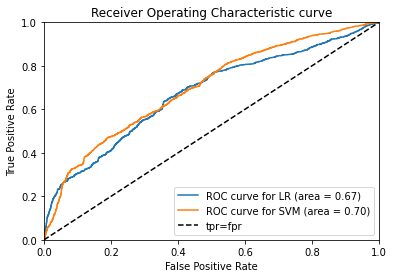

In [ ]:
import pylab as pl
pl.clf()
pl.plot(fpr_LR_OS, tpr_LR_OS, label='ROC curve for LR (area = %0.2f)' % roc_auc_LR_OS)
pl.plot(fpr_SVM_OS, tpr_SVM_OS, label='ROC curve for SVM (area = %0.2f)' % roc_auc_SVM_OS)
pl.plot([0, 1], [0, 1], 'k--',label='tpr=fpr')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver Operating Characteristic curve')
pl.legend()
pl.show()

Text(0.5, 1.0, 'Precision-Recall curve  0.4235859987280974')

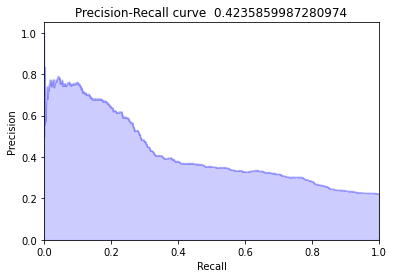

In [ ]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, y_pred_prob_LR_OS)

#print('Average precision-recall score RF: {}'.format(average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision_LR, recall_LR, _ = precision_recall_curve(y_test, y_pred_prob_LR_OS)

plt.step(recall_LR, precision_LR, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_LR, precision_LR, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve  {}".format(average_precision))

In [ ]:
###UNDERSAMPLING


In [ ]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))


Before Undersampling, counts of label '1': 4977
Before Undersampling, counts of label '0': 17523 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Undersampling, the shape of train_X: (9954, 5)
After Undersampling, the shape of train_y: (9954,) 

After Undersampling, counts of label '1': 4977
After Undersampling, counts of label '0': 4977


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_LR_US = LogisticRegression(random_state = 0)
classifier_LR_US.fit(X_train_miss,y_train_miss)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_LR_US= classifier_LR_US.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_LR_US= confusion_matrix(y_test, y_pred_LR_US)
print ("Confusion Matrix : \n", cm_LR_US)

Confusion Matrix : 
 [[3675 2166]
 [ 623 1036]]


In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_LR_US))

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_LR_US, average='binary')
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_LR_US, average='binary')
print('Recall: %.3f' % recall)

from sklearn.metrics import f1_score
score = f1_score(y_test, y_pred_LR_US, average='binary')
print('F-Measure: %.3f' % score)

Accuracy :  0.6281333333333333
Precision: 0.324
Recall: 0.624
F-Measure: 0.426


In [ ]:
from sklearn.svm import SVC
classifier_SVM_US=SVC(kernel='rbf',random_state=0)
classifier_SVM_US.fit(X_train_miss,y_train_miss)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_SVM_US= classifier_SVM_US.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_SVM_US= confusion_matrix(y_test, y_pred_SVM_US)
print ("Confusion Matrix : \n", cm_SVM_US)

Confusion Matrix : 
 [[2152 3689]
 [ 279 1380]]


In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred_SVM_US))

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_SVM_US, average='binary')
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_SVM_US, average='binary')
print('Recall: %.3f' % recall)

from sklearn.metrics import f1_score
score = f1_score(y_test, y_pred_SVM_US, average='binary')
print('F-Measure: %.3f' % score)


specificity1 = cm_SVM_US[0,0]/(cm_SVM_US[0,0]+cm_SVM_US[0,1])
print('Specificity : ', specificity1)

Accuracy :  0.4709333333333333
Precision: 0.272
Recall: 0.832
F-Measure: 0.410
Specificity :  0.3684300633453176


In [ ]:
# Get predicted probabilities
y_pred_prob_LR_US= classifier_LR_US.predict_proba(X_test)[:,1]
#y_pred_prob_SVM = classifier_SVM.predict_proba(X_test)[:,1]

fpr_LR_US, tpr_LR_US, thresholds_LR_US = roc_curve(y_test,y_pred_prob_LR_US)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test,y_pred_prob_SVM)
roc_auc_LR_US= auc(fpr_LR_US, tpr_LR_US)
roc_auc_SVM= auc(fpr_SVM, tpr_SVM)
print("Area under the ROC curve for Logistic regression is  : %f" % roc_auc_LR_US)
print("Area under the ROC curve for SVM is  : %f" % roc_auc_SVM)

Area under the ROC curve for Logistic regression is  : 0.681952
Area under the ROC curve for SVM is  : 0.643799


0    23364
1     6636
Name: default.payment.next.month, dtype: int64


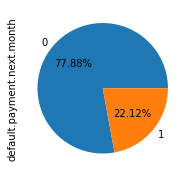

In [ ]:
plt.figure(figsize=(3,3))
print(pd.Series(df['default.payment.next.month']).value_counts())
pd.Series(df['default.payment.next.month']).value_counts().plot(kind ='pie', autopct='%1.2f%%')